In [1]:
import xarray as xr
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import os 
import metpy 
import metpy.calc as mpcalc 
from metpy.plots import SkewT
from metpy.units import units
from IPython.display import HTML, display 
import imageio
from tqdm import tqdm
from itertools import product
import wrf 

Cannot import USCOUNTIES and USSTATES without Cartopy installed.


In [2]:
#Create Paths For Data Collection
path1 =  '/storage/work/bsh5393/storm9/'
path2 =  '/storage/work/bsh5393/storm16/'

#Create A List of File Names For Each Storm
storm9_files = os.listdir(path1)
storm16_files = os.listdir(path2)

#Remove Unneccessary Files From Each List
storm16_files.remove('README-TIMELEVELS')
storm16_files.remove('namelist.input')
storm16_files.remove('runstorm16.pbs.o44255112')
storm16_files.remove('cm1out_stats.nc')
storm9_files.remove('README-TIMELEVELS')
storm9_files.remove('renumber')

In [3]:
#Take a Peek at the Data
peek = xr.open_dataset(path2+storm16_files[-1])
peek

<xarray.Dataset>
Dimensions:   (ni: 1700, nip1: 1701, nj: 1700, njp1: 1701, nk: 121, nkp1: 122, one: 1, time: 1)
Coordinates:
  * time      (time) timedelta64[ns] 14:00:00
Dimensions without coordinates: ni, nip1, nj, njp1, nk, nkp1, one
Data variables:
    f_cor     (one) float32 ...
    ztop      (one) float32 ...
    xh        (ni) float32 ...
    xf        (nip1) float32 ...
    yh        (nj) float32 ...
    yf        (njp1) float32 ...
    z         (nk) float32 ...
    zf        (nkp1) float32 ...
    svs       (time, nj, ni) float32 ...
    svs2      (time, nj, ni) float32 ...
    cref      (time, nj, ni) float32 ...
    th        (time, nk, nj, ni) float32 ...
    thpert    (time, nk, nj, ni) float32 ...
    prs       (time, nk, nj, ni) float32 ...
    prspert   (time, nk, nj, ni) float32 ...
    qv        (time, nk, nj, ni) float32 ...
    qc        (time, nk, nj, ni) float32 ...
    qr        (time, nk, nj, ni) float32 ...
    qi        (time, nk, nj, ni) float32 ...
    qs        (time, nk, nj, ni) float32 ...
    qg        (time, nk, nj, ni) float32 ...
    qhl       (time, nk, nj, ni) float32 ...
    ccn       (time, nk, nj, ni) float32 ...
    ccw       (time, nk, nj, ni) float32 ...
    crw       (time, nk, nj, ni) float32 ...
    cci       (time, nk, nj, ni) float32 ...
    csw       (time, nk, nj, ni) float32 ...
    chw       (time, nk, nj, ni) float32 ...
    chl       (time, nk, nj, ni) float32 ...
    vhw       (time, nk, nj, ni) float32 ...
    vhl       (time, nk, nj, ni) float32 ...
    dbz       (time, nk, nj, ni) float32 ...
    buoyancy  (time, nk, nj, ni) float32 ...
    uinterp   (time, nk, nj, ni) float32 ...
    vinterp   (time, nk, nj, ni) float32 ...
    winterp   (time, nk, nj, ni) float32 ...
    xvort     (time, nk, nj, ni) float32 ...
    yvort     (time, nk, nj, ni) float32 ...
    zvort     (time, nk, nj, ni) float32 ...
    upert     (time, nk, nj, nip1) float32 ...
    vpert     (time, nk, njp1, ni) float32 ...
Attributes:
    x_units:     km
    x_label:     x
    y_units:     km
    y_label:     y
    z_units:     km
    z_label:     z
    nx:          1700
    ny:          1700
    nz:          121
    imoist:      1
    iturb:       1
    tconfig:     1
    bcturbs:     1
    ptype:       27
    wbc:         1
    ebc:         1
    sbc:         1
    nbc:         1
    bbc:         3
    tbc:         1
    iorigin:     2
    axisymm:     0
    iptra:       0
    npt:         1
    fcor:        1e-04
    radopt:      0
    dtrad:       300.0
    ctrlat:      36.68
    ctrlon:      -98.35
    year:        2009
    month:       5
    day:         15
    hour:        21
    minute:      38
    second:      0
    sfcmodel:    1
    oceanmodel:  1
    ipbl:        0
    iice:        1
    idm:         1
    idmplus:     1
    numq:        16
    nql1:        2
    nql2:        3
    nqs1:        4
    nqs2:        7
    nnc1:        8
    nnc2:        14
    nzl1:        1
    nzl2:        1
    nvl1:        15
    nvl2:        16
    c_m:         0.1
    c_e1:        0.20000169
    c_e2:        0.7869588
    c_s:         0.17841241
    cgs1:        1.875
    cgs2:        -1.25
    cgs3:        0.375
    dgs1:        -2.0
    dgs2:        3.0
    dgs3:        -1.0
    cgt1:        1.8757612
    cgt2:        -1.2530508
    cgt3:        0.37728962
    dgt1:        2.0020297
    dgt2:        -3.0081353
    dgt3:        1.0061057

In [4]:
#Start Creating Global Variables for All Storms

#Dataset Sizes
ni = peek['ni']
nj = peek['nj']
nk = peek['nk']

#Datapoint Locations
x_data = peek['xh']*units.kilometer
y_data = peek['yh']*units.kilometer
z_data = peek['z']*units.kilometer

#Grid Locations (n+1)
x_grid = peek['xf']*units.kilometer
y_grid = peek['yf']*units.kilometer
z_grid = peek['zf']*units.kilometer

#Time
time = []
for x in range(len(storm9_files)):
    t = xr.open_dataset(path1 + storm9_files[x])['time']
    time.append(t)

# **List Of Tasks (Storm 16)**

1) Horizontal Cross Sections of CAPE, CIN, SRH(1km and 3km), w(15 m and 500m) 

2) Box and Whisker Plots For These Variables 

3) Hodograph Variability 
    - Compute Bunkers Motion For Each Hodograph 
4) Scatter Plots and Correlations Between Variables

5) Repeat 1)-4) at t = 2hrs in the inflow region of the storm

6) Complete Pseudohodographs and Pseudosoundings, look at variability in spread. 

7) Extra: Are there any "sickle" hodographs, and if so, where? 
    

# **Task 1: Horizontal Cross Sections**

In [24]:
#Need to Specify Bounds For ~25km x 25km Box (Pick It To Be in the Middle of Domain)

#midpoint = round(len(x_data)/2)-1 #Roughly the Middle of the Domain (Not Exact Because Even Number of Points)
#slope = (x_data[2]-x_data[1]).values #Distance Between Each Point
#num_points = round(25/2/slope)
#upper_bound = midpoint + num_points + 1
#lower_bound = midpoint - num_points 

# Load necessary data only once
storm_data = xr.open_dataset(path2 + storm16_files[-1])

#Create New Lower/Upper Bound Variables Since We are not in the center of the domain anymore
lower_bound_x = np.abs(x_data.values - (x_data[-1].values-25)).argmin()-2
upper_bound_x = np.abs(x_data.values - (x_data[-1].values)).argmin()
lower_bound_y = np.abs(y_data.values - 15).argmin()
upper_bound_y = np.abs(y_data.values - 40).argmin()+1
horiz_length = upper_bound_y-lower_bound_y
#check to make sure that the dimension size of the domain matches the domain size from t = 0hrs (that's why it's offset by -2)
print(f'{upper_bound_x-lower_bound_x} {upper_bound_y-lower_bound_y}')

335 335


/storage/home/bsh5393/new/lib64/python3.6/site-packages/ipykernel_launcher.py:5: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  """


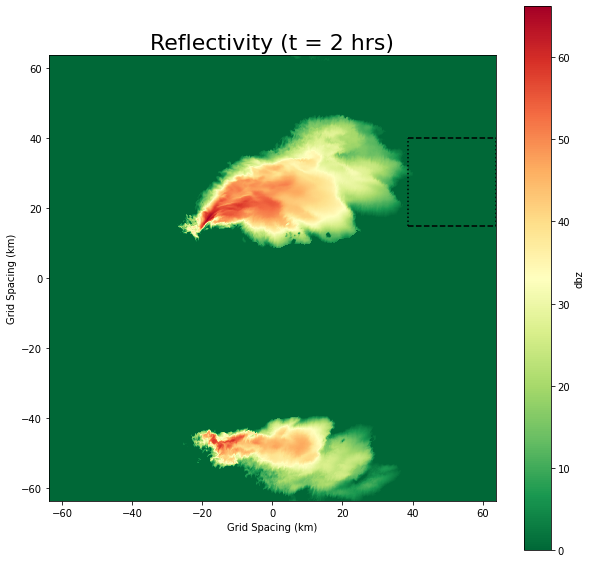

In [27]:
#Plot Potential Temperature Field at t = 0 to get a lay of the land/box of interest

fig = plt.figure(figsize = (10,10))
ax = fig.add_subplot(111)
plt.pcolormesh(x_data,y_data, xr.open_dataset(path2+storm16_files[-1])['dbz'][0][0], cmap='RdYlGn_r')

#Set Box Bounds
lower_bound_x, upper_bound_x = x_data[lower_bound_x],x_data[upper_bound_x]
lower_bound_y, upper_bound_y = y_data[lower_bound_y], y_data[upper_bound_y]

#Plot Box of Domain of Interest
#Plot horizontal lines for the top and bottom of the box
ax.plot([lower_bound_x, upper_bound_x], [lower_bound_y, lower_bound_y], color='k', linestyle='--')
ax.plot([lower_bound_x, upper_bound_x], [upper_bound_y, upper_bound_y], color='k', linestyle='--')

# Plot vertical lines for the left and right of the box
ax.plot([lower_bound_x, lower_bound_x], [lower_bound_y, upper_bound_y], color='k', linestyle=':')
ax.plot([upper_bound_x, upper_bound_x], [lower_bound_y, upper_bound_y], color='k', linestyle=':')


#Add Labels
plt.title('Reflectivity (t = 2 hrs)', fontsize = 22)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
ax.set_aspect('equal')
clb = plt.colorbar()
clb.set_label('dbz')


In [59]:
#CAPE-CIN (ALL AT ONCE)

#CAPE-CIN

#Import Data
QV = storm_data['qv'].loc[:,:,lower_bound_y:upper_bound_y,lower_bound_x:upper_bound_x][0] #Assume SH~Water Vapor Mass Fraction (Ask Paul if Correct)
P = storm_data['prs'].loc[:,:,lower_bound_y:upper_bound_y,lower_bound_x:upper_bound_x][0]/100 #pressure at gridpoint
Th = storm_data['th'].loc[:,:,lower_bound_y:upper_bound_y,lower_bound_x:upper_bound_x][0] #potential temp at gridpoint

#For the WRF CAPE Function We Need: Total Pressure (hPa), Temperature (degK), Water Vapor Mixing Ratio (kg/kg), *Geopotential Height* (m), Terrain Height (m), Surface Pressure (hPa)
T = mpcalc.temperature_from_potential_temperature(P*units.hPa,Th*units.kelvin) #Temperature from Potential Temperature
z = np.asarray(z_data*1000).reshape(121,1,1) #"Geopotential Height"
Height = np.tile(z, (1, horiz_length, horiz_length)) #"Geopotential Height"
Terrain = np.full((horiz_length,horiz_length),0) #Terrain (Assuming Flat Surface)
P_sfc = P[0].values #Surface Pressure

#WRF CAPE Computation
results = wrf.cape_3d(P,T,QV,Height,Terrain, P_sfc, ter_follow = True,meta= True)


/storage/home/bsh5393/test/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


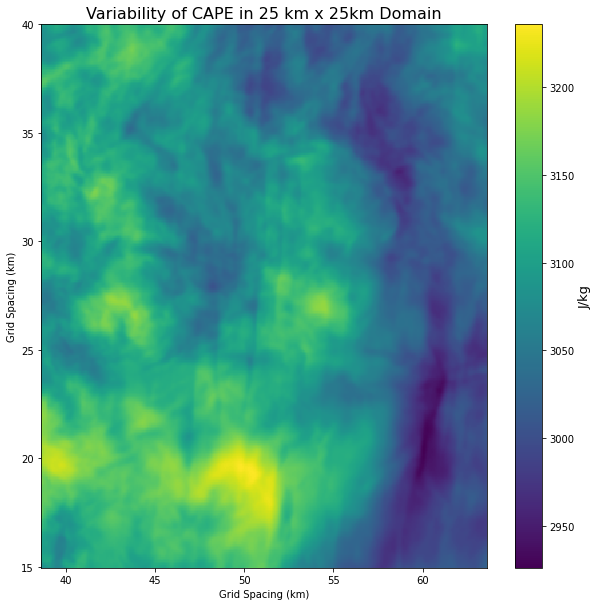

In [60]:
#Plot CAPE Field

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[lower_bound_x:upper_bound_x], y_data[lower_bound_y:upper_bound_y], results[0][0])
plt.title('Variability of CAPE in 25 km x 25km Domain', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar()
clb.set_label('J/kg', fontsize = 13)

/storage/home/bsh5393/test/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


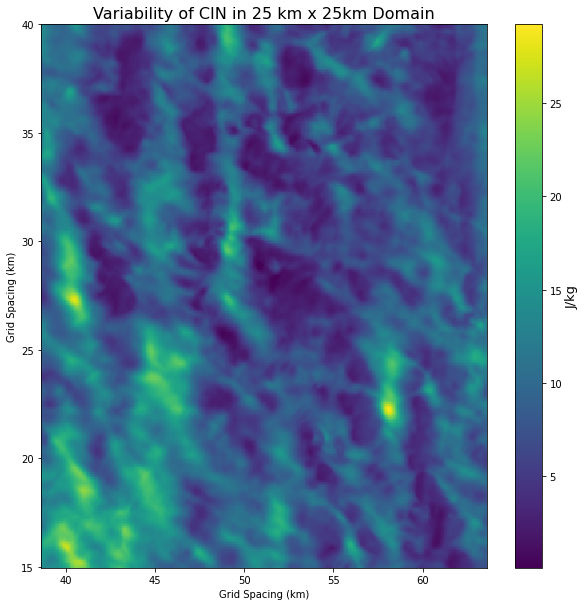

In [61]:
#Plot CIN Field

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[lower_bound_x:upper_bound_x], y_data[lower_bound_y:upper_bound_y], results[1][0])
plt.title('Variability of CIN in 25 km x 25km Domain', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar()
clb.set_label('J/kg', fontsize = 13)

In [62]:
#SRH1km and SRH3km

#Import Data
u = storm_data['uinterp'].loc[:,:,lower_bound_y:upper_bound_y,lower_bound_x:upper_bound_x][0]
v = storm_data['vinterp'].loc[:,:,lower_bound_y:upper_bound_y,lower_bound_x:upper_bound_x][0]

#For the WRF SRH Function We Need: U (m/s), V (m/s), Height (m), Terrain (m), Top (m)
Height = Height
Terrain = np.full((horiz_length,horiz_length),0)

SRH1km = wrf.srhel(u,v,Height, Terrain, top = 1000)
SRH3km = wrf.srhel(u,v,Height, Terrain, top = 3000)



/storage/home/bsh5393/test/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


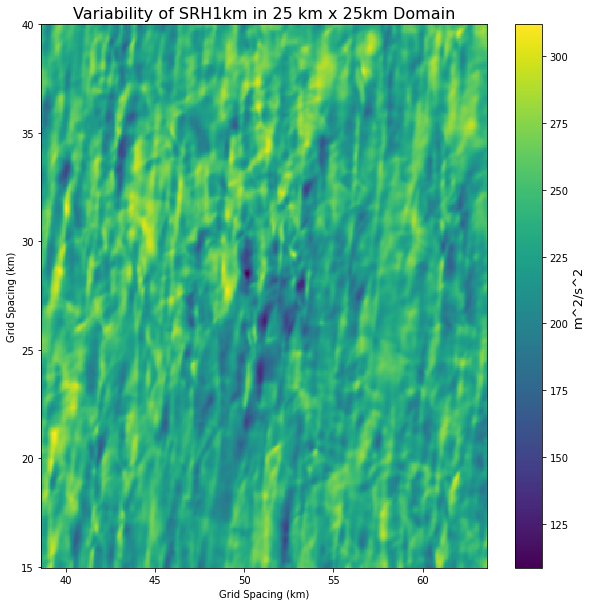

In [63]:
#Plot SRH1km Field

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[lower_bound_x:upper_bound_x], y_data[lower_bound_y:upper_bound_y], SRH1km)
plt.title('Variability of SRH1km in 25 km x 25km Domain', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar()
clb.set_label('m^2/s^2', fontsize = 13)

/storage/home/bsh5393/test/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  


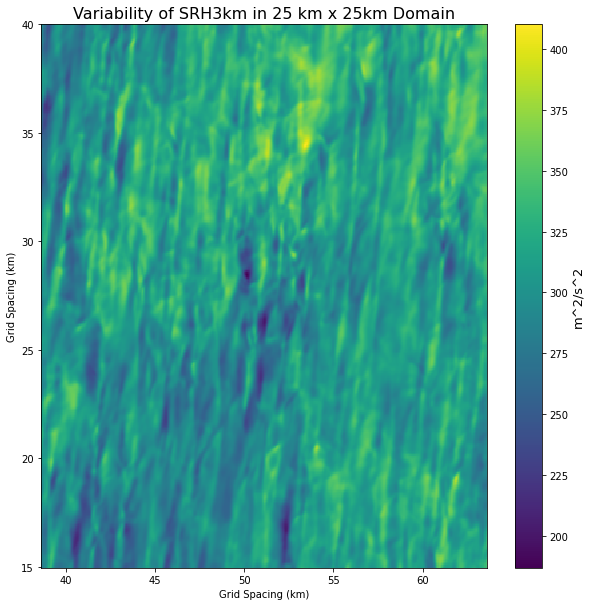

In [64]:
#Plot SRH3km Field

fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)

plt.pcolormesh(x_data[lower_bound_x:upper_bound_x], y_data[lower_bound_y:upper_bound_y], SRH3km)
plt.title('Variability of SRH3km in 25 km x 25km Domain', fontsize = 16)
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar()
clb.set_label('m^2/s^2', fontsize = 13)

/storage/home/bsh5393/test/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/storage/home/bsh5393/test/lib64/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


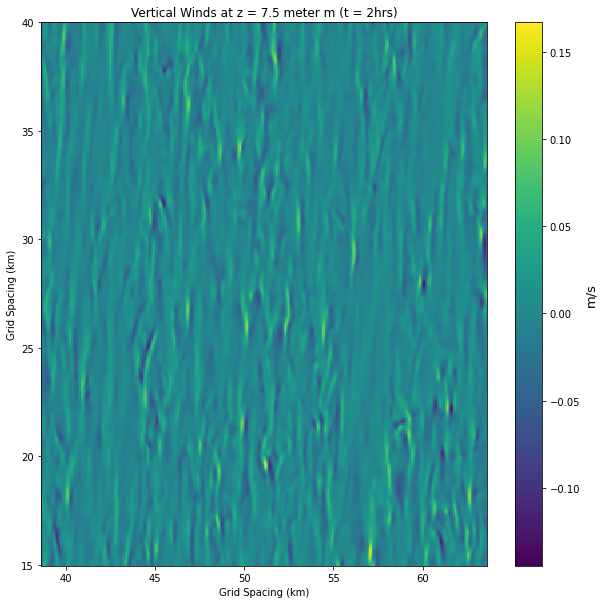

In [65]:
#Plot Vertical Winds At z = 7.5 m

w_75 = xr.open_dataset(path2+storm16_files[0])['winterp'].loc[:,0,lower_bound_y:upper_bound_y,lower_bound_x:upper_bound_x][0]
height_level = round((z_data[0].values*1000),2)*units.m
plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.pcolormesh(x_data[lower_bound_x:upper_bound_x], y_data[lower_bound_y:upper_bound_y],w_75)
plt.title(f'Vertical Winds at z = {height_level} m (t = 2hrs)')
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar()
clb.set_label('m/s', fontsize = 13)

/storage/home/bsh5393/test/lib64/python3.6/site-packages/ipykernel_launcher.py:6: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  
/storage/home/bsh5393/test/lib64/python3.6/site-packages/ipykernel_launcher.py:7: MatplotlibDeprecationWarning: shading='flat' when X and Y have the same dimensions as C is deprecated since 3.3.  Either specify the corners of the quadrilaterals with X and Y, or pass shading='auto', 'nearest' or 'gouraud', or set rcParams['pcolor.shading'].  This will become an error two minor releases later.
  import sys


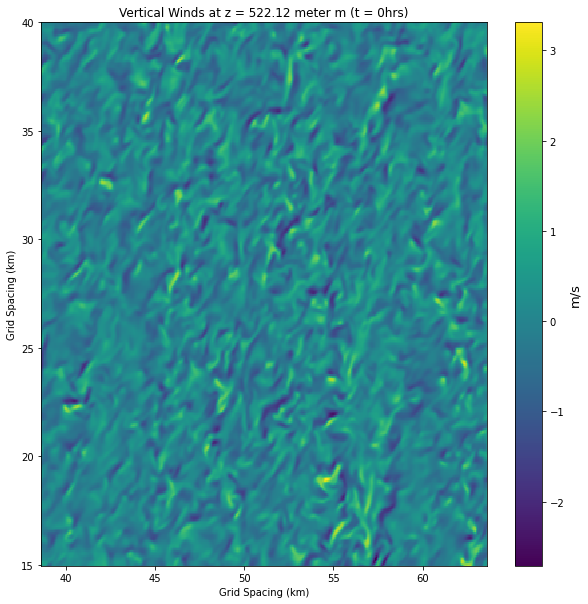

In [66]:
#Plot Vertical Winds At z = 500 m

w_500 = xr.open_dataset(path2+storm16_files[0])['winterp'].loc[:,17,lower_bound_y:upper_bound_y,lower_bound_x:upper_bound_x][0]
height_level = round((z_data[17].values*1000),2)*units.m
plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
plt.pcolormesh(x_data[lower_bound_x:upper_bound_x], y_data[lower_bound_y:upper_bound_y],w_500)
plt.title(f'Vertical Winds at z = {height_level} m (t = 0hrs)')
plt.xlabel('Grid Spacing (km)')
plt.ylabel('Grid Spacing (km)')
clb = plt.colorbar()
clb.set_label('m/s', fontsize = 13)

# **Task 2: Box & Whisker Plots**

In [67]:
#First Need To Convert Our Dataframes to 1D Arrays
data_CAPE = np.asarray(results[0][0]).reshape(horiz_length*horiz_length)
data_CIN = np.asarray(results[1][0]).reshape(horiz_length*horiz_length)
data_SRH1km = np.asarray(SRH1km).reshape(horiz_length*horiz_length)
data_SRH3km = np.asarray(SRH3km).reshape(horiz_length*horiz_length)
data_w_75 = np.asarray(w_75).reshape(horiz_length*horiz_length)
data_w_500 = np.asarray(w_500).reshape(horiz_length*horiz_length)

Text(0.5, 1.0, 'w @ z = 500 m (m/s)')

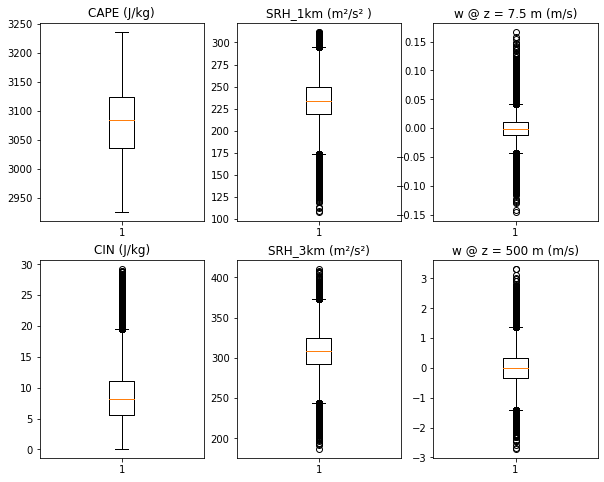

In [68]:
#Plot Box and Whisker Plots For ALL Parameters (w/ Outlier Points)

fig, axs = plt.subplots(nrows =2, ncols = 3, figsize = (10,8))

#CAPE
axs[0,0].boxplot(data_CAPE)
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(data_CIN)
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(data_SRH1km)
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2 )')

#SRH3km
axs[1,1].boxplot(data_SRH3km)
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w_7.5
axs[0,2].boxplot(data_w_75)
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w_500
axs[1,2].boxplot(data_w_500)
axs[1,2].set_title('w @ z = 500 m (m/s)')



Text(0.5, 1.0, 'w @ z = 500 m (m/s)')

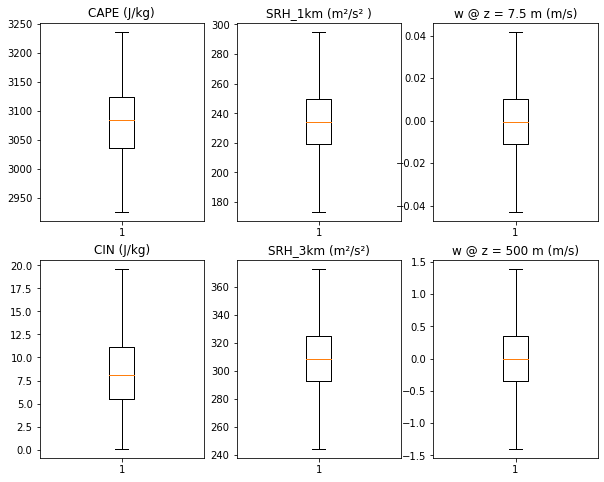

In [69]:
#Plot Box and Whisker Plots For ALL Parameters (w/o Outlier Points)

fig, axs = plt.subplots(nrows =2, ncols = 3, figsize = (10,8))

#CAPE
axs[0,0].boxplot(data_CAPE, 0, '')
axs[0,0].set_title('CAPE (J/kg)')

#CIN
axs[1,0].boxplot(data_CIN, 0, '')
axs[1,0].set_title('CIN (J/kg)')

#SRH1km 
axs[0,1].boxplot(data_SRH1km, 0, '')
axs[0,1].set_title('SRH_1km (m\u00b2/s\u00b2 )')

#SRH3km
axs[1,1].boxplot(data_SRH3km, 0, '')
axs[1,1].set_title('SRH_3km (m\u00b2/s\u00b2)')

#w_7.5
axs[0,2].boxplot(data_w_75, 0, '')
axs[0,2].set_title('w @ z = 7.5 m (m/s)')

#w_500
axs[1,2].boxplot(data_w_500, 0, '')
axs[1,2].set_title('w @ z = 500 m (m/s)')



In [72]:
#Create Code That Saves All Relevant Data

CAPE = results[0]
CIN = results[1]


computations_25km_domain = xr.Dataset({
    'CAPE': xr.DataArray(
        data = CAPE,
        coords = {'x-direction': ni[lower_bound_x:upper_bound_x], 'y-direction':nj[lower_bound_y:upper_bound_y], 'z-direction':nk},
        attrs = {'units': 'J/kg', 'description': 'Convective Available Potential Energy'}
        ),
    
    'CIN': xr.DataArray(
        data = CIN,
        coords = {'x-direction': ni[lower_bound_x:upper_bound_x], 'y-direction':nj[lower_bound_y:upper_bound_y], 'z-direction':nk},
        attrs = {'units': 'J/kg', 'description': 'Convective Inhibition'}
        ),
    
    'SRH1km': xr.DataArray(
        data = SRH1km,
        attrs = {'units': 'm\u00b2/s\u00b2', 'description': 'Storm Relative Helicity for Lowest 1km'}
        ),
    
    'SRH3km': xr.DataArray(
        data = SRH3km,
        attrs = {'units': 'm\u00b2/s\u00b2', 'description': 'Storm Relative Helicity for Lowest 3km'}
        ),
    'w_7.5': xr.DataArray(
        data = w_75,
        coords = {'x-direction': ni[lower_bound_x:upper_bound_x], 'y-direction':nj[lower_bound_y:upper_bound_y]},
        attrs = {'units': 'm/s', 'description': 'Vertical Winds at z = 7.5 m (Lowest Level of Data)'}
        ),
    'w_500': xr.DataArray(
        data = w_500,
        coords = {'x-direction': ni[lower_bound_x:upper_bound_x], 'y-direction':nj[lower_bound_y:upper_bound_y]},
        attrs = {'units': 'm/s', 'description': 'Vertical Winds at z = 500 m'}
        ),        
})

#Create FilePath and Save Data
computations_path = '/storage/work/bsh5393/Masters Thesis/Original Variability Study/Data/'
filename = computations_path + 'computations25kmx25km(t=2hrs).nc'
computations_25km_domain.to_netcdf(filename, 'w')

